Imports

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import pyodbc
import sqlite3
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

Gather data

In [33]:
def getDbAsDF(conn: sqlite3.Connection, sql: str):
    cursor = conn.cursor()
    cursor.execute(sql)
    data = cursor.fetchall()

    columns = [column[0] for column in cursor.description]

    formatted_data = {}

    for i in range(len(columns)):
        dataList = []
        for j in data:
            dataList.append(j[i])
        formatted_data[columns[i]] = dataList

    df = pd.DataFrame(data=formatted_data, columns=columns)
    return df

# Connect to SQLite database
salesConn = sqlite3.connect(r'..\..\Data\merged.sqlite')

salesSQL = """
SELECT *
FROM returned_item
INNER JOIN return_reason ON returned_item.RETURN_REASON_CODE = return_reason.RETURN_REASON_CODE
INNER JOIN order_details ON returned_item.ORDER_DETAIL_CODE = order_details.ORDER_DETAIL_CODE
INNER JOIN order_header ON order_header.ORDER_NUMBER = order_details.ORDER_NUMBER
INNER JOIN sales_sales_branch ON sales_sales_branch.SALES_BRANCH_CODE = order_header.SALES_BRANCH_CODE
INNER JOIN sales_country ON sales_country.COUNTRY_CODE = sales_sales_branch.COUNTRY_CODE
INNER JOIN product ON product.PRODUCT_NUMBER = order_details.PRODUCT_NUMBER
INNER JOIN product_type ON product_type.PRODUCT_TYPE_CODE = product.PRODUCT_TYPE_CODE
INNER JOIN crm_retailer_site ON crm_retailer_site.RETAILER_SITE_CODE = order_header.RETAILER_SITE_CODE
INNER JOIN retailer ON retailer.RETAILER_CODE = crm_retailer_site.RETAILER_CODE
INNER JOIN retailer_headquarters ON retailer_headquarters.RETAILER_CODEMR = retailer.RETAILER_CODEMR
"""

salesDF = getDbAsDF(salesConn, salesSQL)
salesDF.columns

Index(['RETURN_CODE', 'RETURN_DATE', 'ORDER_DETAIL_CODE', 'RETURN_REASON_CODE',
       'RETURN_QUANTITY', 'RETURN_REASON_CODE', 'RETURN_DESCRIPTION_EN',
       'ORDER_DETAIL_CODE', 'ORDER_NUMBER', 'PRODUCT_NUMBER', 'QUANTITY',
       'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'ORDER_NUMBER',
       'RETAILER_NAME', 'RETAILER_SITE_CODE', 'RETAILER_CONTACT_CODE',
       'SALES_STAFF_CODE', 'SALES_BRANCH_CODE', 'ORDER_DATE',
       'ORDER_METHOD_CODE', 'SALES_BRANCH_CODE', 'ADDRESS1', 'ADDRESS2',
       'CITY', 'REGION', 'POSTAL_ZONE', 'COUNTRY_CODE', 'COUNTRY_CODE',
       'COUNTRY', 'LANGUAGE', 'CURRENCY_NAME', 'PRODUCT_NUMBER',
       'INTRODUCTION_DATE', 'PRODUCT_TYPE_CODE', 'PRODUCTION_COST', 'MARGIN',
       'PRODUCT_IMAGE', 'LANGUAGE', 'PRODUCT_NAME', 'DESCRIPTION',
       'PRODUCT_TYPE_CODE', 'PRODUCT_LINE_CODE', 'PRODUCT_TYPE_EN',
       'RETAILER_SITE_CODE', 'RETAILER_CODE', 'ADDRESS1', 'ADDRESS2', 'CITY',
       'REGION', 'POSTAL_ZONE', 'COUNTRY_CODE', 'ACTIVE_INDICATOR',
  

Selecting suitable data

In [34]:
workingDF = salesDF[["RETURN_QUANTITY","RETURN_REASON_CODE","ORDER_METHOD_CODE","COUNTRY_CODE","PRODUCT_TYPE_CODE","SALES_BRANCH_CODE","UNIT_PRICE","PRODUCTION_COST","PRODUCT_NUMBER","RETAILER_TYPE_CODE","COUNTRY_CODE","SEGMENT_CODE"]] # Don't know why this duplication happens 
workingDF = workingDF.T.drop_duplicates().T # But fix it here
workingDF.dropna(inplace = True)
print(workingDF.head())
print(workingDF.columns)

  RETURN_QUANTITY RETURN_REASON_CODE ORDER_METHOD_CODE COUNTRY_CODE  \
0               8                  5                 2            5   
1               8                  5                 2            5   
2               8                  5                 2            5   
3               8                  5                 2            5   
4               8                  5                 2            5   

  PRODUCT_TYPE_CODE SALES_BRANCH_CODE UNIT_PRICE PRODUCTION_COST  \
0                 1                39     123.56           85.11   
1                 1                39     123.56           85.11   
2                 1                39     123.56           85.11   
3                 1                39     123.56           85.11   
4                 1                39     123.56           85.11   

  PRODUCT_NUMBER RETAILER_TYPE_CODE SEGMENT_CODE  
0              6                  2            5  
1              6                  2            5  
2          

Creating correlation heatmap

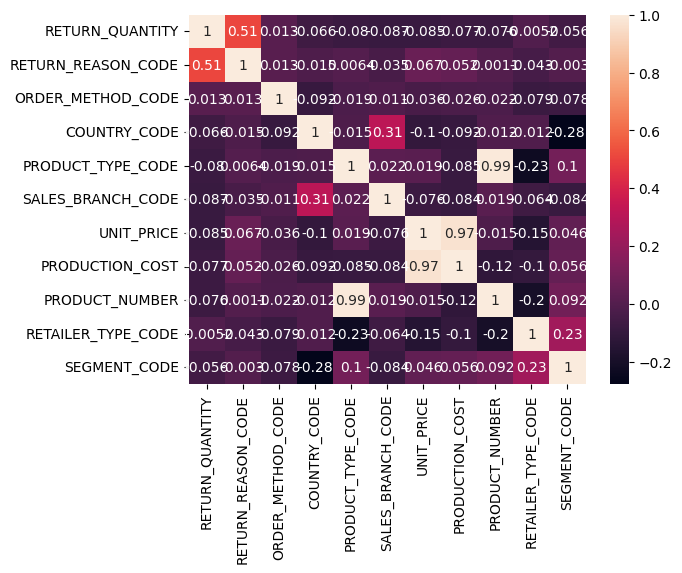

In [35]:
corr_matrix = workingDF.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

<Axes: xlabel='RETURN_REASON_CODE', ylabel='RETURN_QUANTITY'>

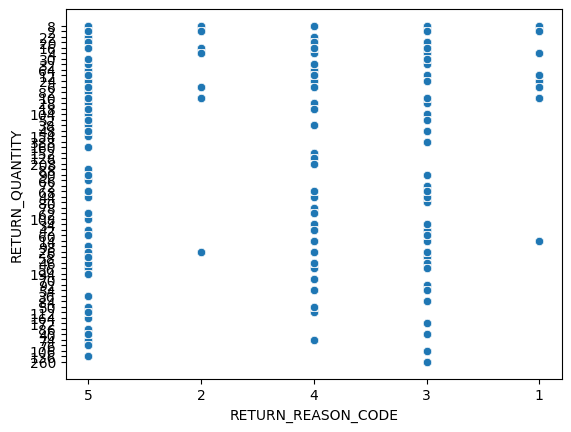

In [36]:
sns.scatterplot(x='RETURN_REASON_CODE',
                y='RETURN_QUANTITY', data=workingDF)

In [37]:
X = workingDF.drop('RETURN_QUANTITY',axis= 1)
y = workingDF['RETURN_QUANTITY']
print(X)
print(y)

       RETURN_REASON_CODE ORDER_METHOD_CODE COUNTRY_CODE PRODUCT_TYPE_CODE  \
0                       5                 2            5                 1   
1                       5                 2            5                 1   
2                       5                 2            5                 1   
3                       5                 2            5                 1   
4                       5                 2            5                 1   
...                   ...               ...          ...               ...   
153851                  2                 7           22                 9   
153852                  2                 7           22                 9   
153853                  2                 7           22                 9   
153854                  2                 7           22                 9   
153855                  2                 7           22                 9   

       SALES_BRANCH_CODE UNIT_PRICE PRODUCTION_COST PRODUCT_NUM

In [38]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)

In [39]:
# creating a regression model
model = LinearRegression()

# fitting the model
model.fit(X_train,y_train)

# making predictions
predictions = model.predict(X_test)


In [40]:
# model evaluation

print(
  'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
  'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  855.4708330312341
mean_absolute_error :  15.449043637651396
